### Estimación de Probabilidades de Caudal Volumétrico Presa Chicayan con Cadenas de Markov

Una **cadena de Markov** es un proceso estocástico donde la probabilidad de transición de un estado (discreto) a otro depende *únicamente del estado actual*, sin considerar el estado anterior. Este concepto, llamado propiedad de Markov, significa que el futuro depende solo del presente, no del pasado.

Este modelo puede aplicarse al **Volumen de Entrada** de la presa, asumiendo que el valor futuro depende en gran medida del valor observado hoy, y calcular probabilidades de transición de acuerdo a las transiciones observadas históricamente. Para ello es necesario *discretizar* el volumen de entrada en estados, por ejemplo, Crítico, Bajo, Medio y Alto. De esta manera, una matriz de probabilidad de transición en la cadena de Markov se vería como sigue:

Ejemplo:

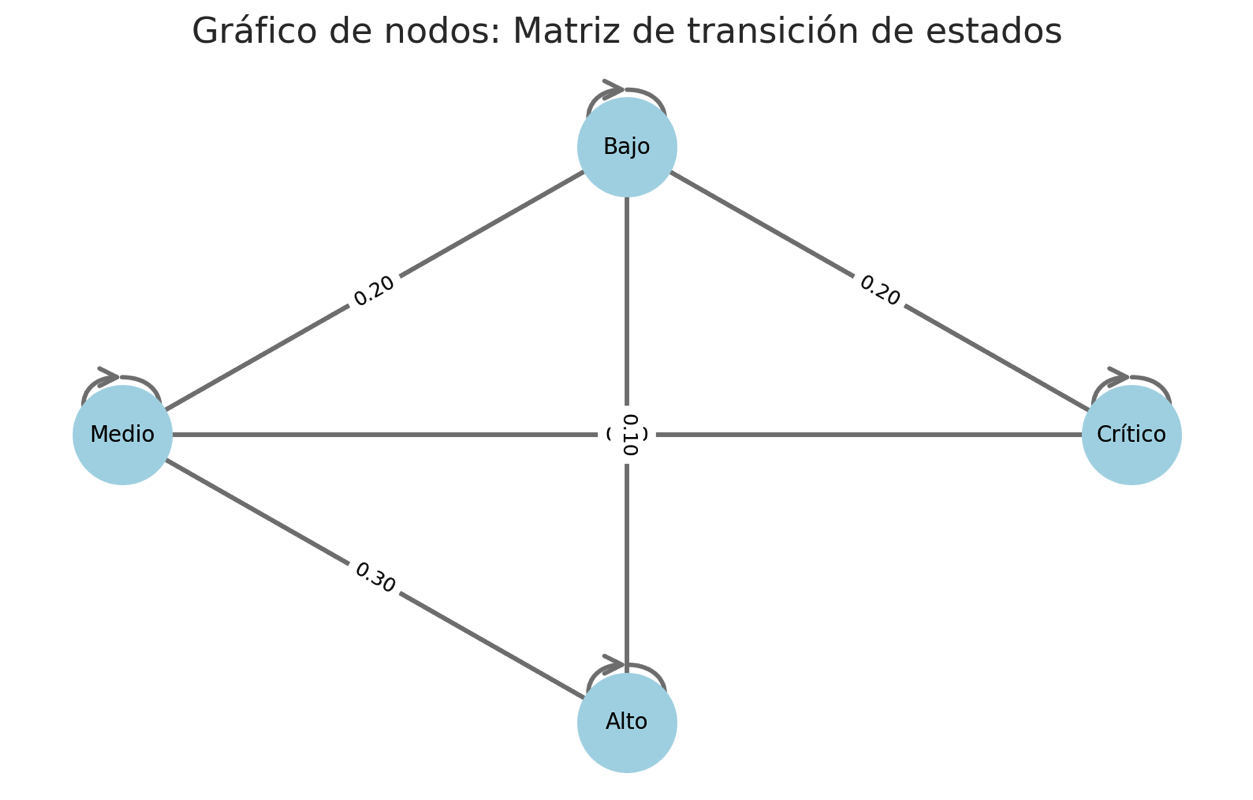

#### Elaboración:

#### Estados:
Una cadena de Markov se caracteriza por un conjunto de estados o condiciones en las que un sistema puede estar. 

#### Transiciones:
El sistema pasa de un estado a otro a través de transiciones, y la probabilidad de pasar a un estado específico depende únicamente del estado actual. 

#### Propiedad de Markov:
La probabilidad de transición de un estado a otro depende solo del estado actual, sin considerar el estado anterior. 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

### Matriz de Transición
Las cadenas de Markov se utilizan sobre eventos discretos. Por lo tanto se necesita una *discretización* del volumen de entrada de la presa en categorías. Se propone la siguiente clasificación:

|Estado|Descripción|Rango (en % del volumen máximo)|
|------|-----------|------------------------------|
|0|Crítico|0-20%|
|1|Bajo|20-40%|
|2|Medio|40-70%|
|3|Alto|70-100%|

Basado en datos históricos anuales, se cuenta cuántas veces hubo una transición de un estado a otro:

|Año t (estado actual)|Año t+1 (estado siguiente)|
|---------------------|--------------------------|
|Medio (2)|Bajo (1)|
|Bajo (1)|Medio (2)|
|Medio (2)|Alto(3)|
|...|...|

Y a partir de esto, se construye la **matriz de transición $P$**:

$$P =
\begin{bmatrix}
p_{00} & p_{01} & p_{02} & p_{03} \\
p_{10} & p_{11} & p_{12} & p_{13} \\
p_{20} & p_{21} & p_{22} & p_{23} \\
p_{30} & p_{31} & p_{32} & p_{33}
\end{bmatrix}
$$

donde $p_{ij}$ es la probabilidad de pasar del estado $i$ al estado $j$, y cada fila suma 1.

#### Discretización de Volumen Operativo de la Presa

Se calcula el volumen operativo de la presa.

In [2]:
data = pd.read_csv(r'Inlet_Dates.csv')
serie = data['Inlet']

In [3]:
def volumen_operativo(inlet_sequence,max_volume,irrigation_outlet,losses):

    balance = []
    max_irrigation_outlet = 0
    min_volume = 135
    balance_previous_year = 229.36

    for i in range(len(inlet_sequence)):
        Vt = inlet_sequence[i] + balance_previous_year
        overflow = max(Vt-max_volume,0)
        net_volume = max(Vt - overflow - irrigation_outlet - losses,0)
        operative_volume = net_volume - min_volume

        registro = [1979+i,inlet_sequence[i],Vt,overflow,balance_previous_year,net_volume,operative_volume]

        balance.append(registro)
    
        balance_previous_year = net_volume

    df = pd.DataFrame(balance,columns=['year','inlet','Vt','overflow','balance_previous_year','net_volume','operative_volume'])
  
    plt.figure(figsize=(10, 5))
    plt.plot(df['year'],df['inlet'],label='Volumen de Entrada')
    minimo = min(df['inlet'])
    maximo = max(df['inlet'])
    rango = maximo - minimo

    # 20%
    plt.axhline(y=0.2*rango+minimo, color='r', linestyle='-',label='20% Volumen Crítico')

    # 40%
    plt.axhline(y=0.4*rango+minimo, color='y', linestyle='-',label='40% Volumen Bajo')

    # 70%
    plt.axhline(y=0.7*rango+minimo, color='g', linestyle='-',label='70% Volumen Medio')
    
    plt.title("Volumen Entrada Presa [Mm3]")
    plt.xlabel("Año")
    plt.ylabel("Volumen Entrada Presa [Mm3]")
    plt.legend()
    plt.grid(True)
    
    return df

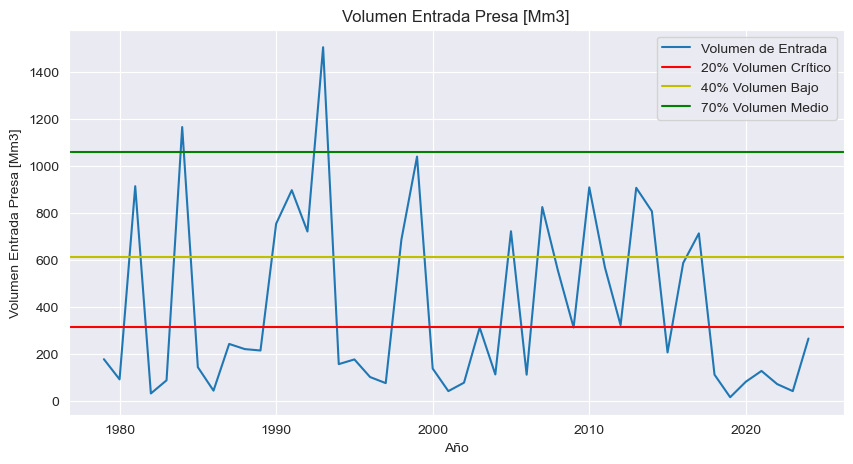

In [4]:
volumen_maximo = 250
salida_irrigacion = 79.2
perdidas = 18
df_volumen = volumen_operativo(serie,volumen_maximo,salida_irrigacion,perdidas)

volumen_operativo_max = max(df_volumen['inlet'])
volumen_operativo_min = min(df_volumen['inlet'])
volumenes_historicos = df_volumen['inlet'].values

In [5]:
def discretizar_volumen(volumen,maximo,minimo):
    """Convierte un volumen en un estado categórico."""

    rango = maximo - minimo
    
    if (volumen < (0.2*rango + minimo)):
        return 0  # Crítico
    elif (volumen < (0.4*rango + minimo)):
        return 1  # Bajo
    elif (volumen < (0.7*rango + minimo)):
        return 2  # Medio
    else:
        return 3  # Alto

In [6]:
# Convertimos los niveles continuos en estados discretos
historical_states = [discretizar_volumen(volumen,volumen_operativo_max,volumen_operativo_min) for volumen in volumenes_historicos]

print("Estados discretizados:")
print(historical_states)

Estados discretizados:
[0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 2, 2, 2, 3, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 2, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0]


### Estimación de la Matriz de Transición

In [7]:
# Inicializamos matriz de conteo
n_states = 4
transition_counts = np.zeros((n_states, n_states), dtype=int)

# Recorremos la serie histórica para contar las transiciones
for (current_state, next_state) in zip(historical_states[:-1], historical_states[1:]):
    transition_counts[current_state, next_state] += 1

# Normalizamos por fila
transition_matrix = transition_counts / transition_counts.sum(axis=1, keepdims=True)

# Mostramos en DataFrame
state_labels = ['Crítico', 'Bajo', 'Medio', 'Alto']
transition_df = pd.DataFrame(transition_matrix, index=state_labels, columns=state_labels)

print("Matriz de transición estimada:")
print(transition_df.round(2))

Matriz de transición estimada:
         Crítico  Bajo  Medio  Alto
Crítico     0.70  0.04   0.22  0.04
Bajo        0.25  0.25   0.50  0.00
Medio       0.42  0.17   0.33  0.08
Alto        1.00  0.00   0.00  0.00


### Simulación de Múltiples trayectorias

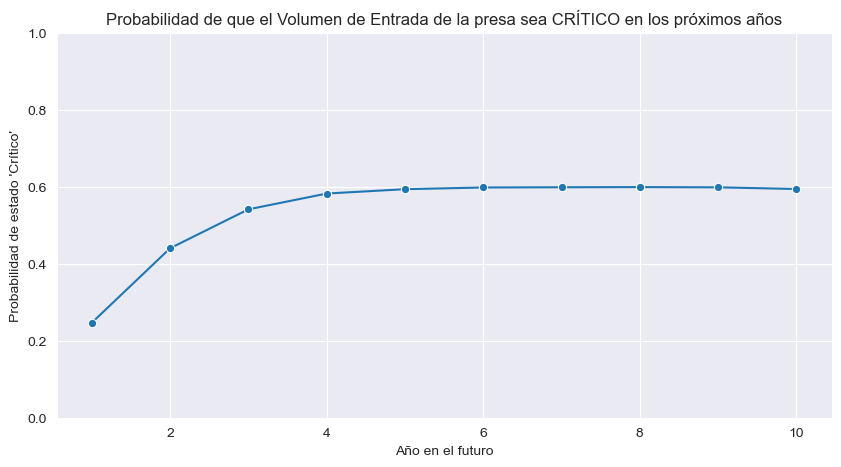

In [8]:
# Definimos los estados: 0 = Crítico, 1 = Bajo, 2 = Medio, 3 = Alto
states = [0, 1, 2, 3]
state_names = ['Crítico', 'Bajo', 'Medio', 'Alto']

n_simulations = 10000
n_years = 10
initial_state = 1  # Supongamos que hoy estamos en "Bajo"

# Simulamos trayectorias
trajectories = np.zeros((n_simulations, n_years), dtype=int)

for i in range(n_simulations):
    state = initial_state
    for t in range(n_years):
        state = np.random.choice(states, p=transition_matrix[state])
        trajectories[i, t] = state

# Cálculo de probabilidades de estar en estado "Crítico" cada año
critical_probs = (trajectories == 0).mean(axis=0)

# Graficamos Probabilidad
plt.figure(figsize=(10, 5))
sns.lineplot(x=np.arange(1, n_years + 1), y=critical_probs, marker='o')
plt.title("Probabilidad de que el Volumen de Entrada de la presa sea CRÍTICO en los próximos años")
plt.xlabel("Año en el futuro")
plt.ylabel("Probabilidad de estado 'Crítico'")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

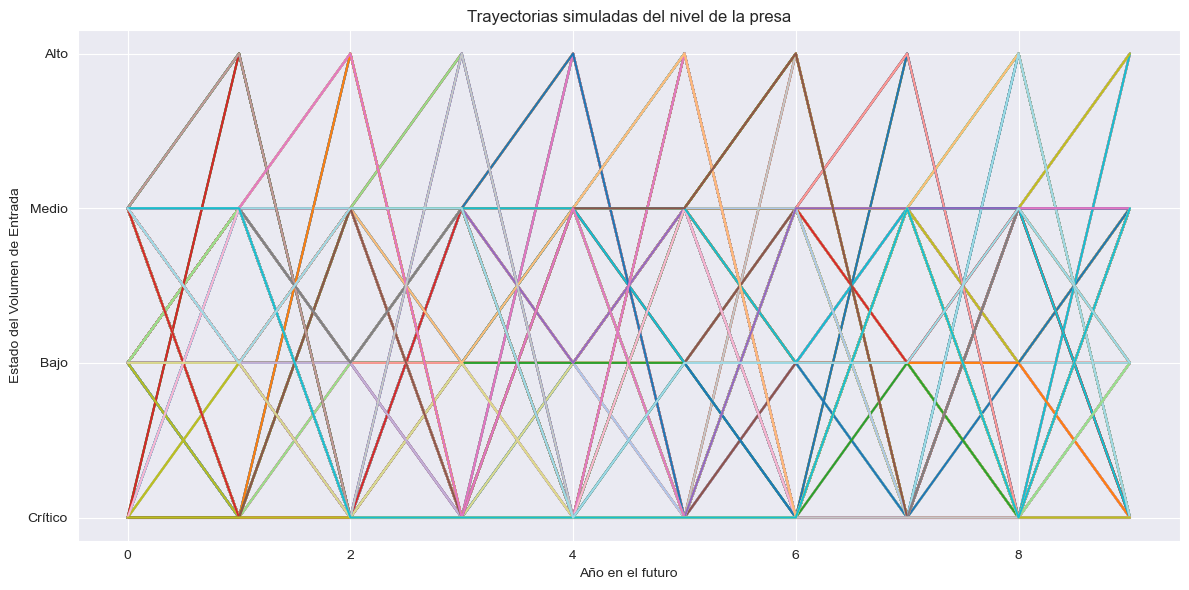

In [9]:
# Seleccionamos un subconjunto de trayectorias para graficar (por ejemplo, 500)
n_to_plot = 500
subset = trajectories[:n_to_plot, :]

# Convertimos a DataFrame largo para seaborn
df_plot = pd.DataFrame(subset)
df_plot['sim_id'] = df_plot.index  # identificador de simulación
df_long = df_plot.melt(id_vars='sim_id', var_name='Año', value_name='Estado')

# Mapear nombres de estado
estado_map = {0: 'Crítico', 1: 'Bajo', 2: 'Medio', 3: 'Alto'}
df_long['Estado_nombre'] = df_long['Estado'].map(estado_map)

# Graficamos las trayectorias
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_long, x='Año', y='Estado', hue='sim_id', palette='tab20', legend=False)
plt.yticks(ticks=[0, 1, 2, 3], labels=['Crítico', 'Bajo', 'Medio', 'Alto'])
plt.title('Trayectorias simuladas del nivel de la presa')
plt.xlabel('Año en el futuro')
plt.ylabel('Estado del Volumen de Entrada')
plt.grid(True)
plt.tight_layout()
plt.show()